# Aufgabe 2 - Variation berechnet mit ngsolve
## Teilaufgabe: Wie sieht die Lösung für ε = ${10^-6}$ nach T = 2s aus?


In [1]:
from netgen.meshing import *
from ngsolve import *
from netgen.meshing import Mesh as NGMesh
from ngsolve.webgui import Draw
from netgen.geom2d import SplineGeometry, unit_square
import matplotlib.pyplot as plt
import numpy as np
import pickle
from ngsolve import CoefficientFunction
from ngsolve.meshes import MakeStructured2DMesh
import time

Hier wird das gegebene Bild mit Hilfe der pickle library illustriert. Dabei belassen wir das Bild in der graustufen Darstellung.

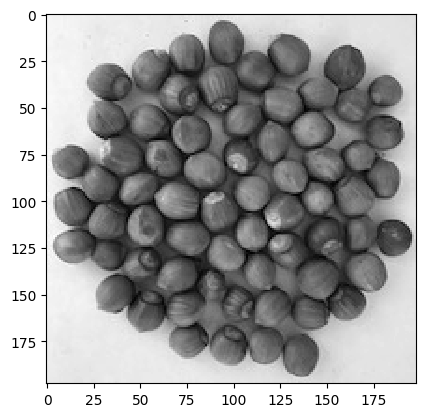

In [2]:
with open('img.pkl','rb') as fp:
    img = pickle.load(fp)
plt.imshow(img,interpolation='none', cmap='gray')

## Dieses mesh wurde in der Aufgabenstelung vorgegeben. Es ist Teil des ngsolve.meshes Moduls, die Dimensionen wurde auf unser Bildproblem angepasst wurde.

In [3]:
mesh = MakeStructured2DMesh(nx=int((img.shape[0]-1)/1),
                            ny=int((img.shape[1]-1)/1),
                            quads=False)
cfImg = VoxelCoefficient((0,0),(1,1),
                         img[np.arange(img.shape[0]-1,-1,-1)])

Hier wird das Problem illustriert, wobei noch keine Phasenseperation ersichtlich ist. Dies aus dem einfachen Grund, da das Funktional nocht nicht auf das Problem (Bild) angewandt wurde. 

In [4]:
Draw(cfImg,mesh,'cfImg')

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [5]:
# Gegeben aus Aufgabenstellung:
eps = 1e-6
dt = 0.1
t0 = 0
tend = 2
t = t0

In [6]:
# FEM Raum
V = H1(mesh, order=2)

# Trial Funktion
u = V.TrialFunction()
# Test Funktion 
v = V.TestFunction()

# GridFunction
gfu = GridFunction(V)

# hier wird die Matrix "gebildet" => gegeben aus Aufgabenstellung
a = BilinearForm (V, symmetric = False)
a += Variation((eps/2*grad(u)*grad(u) 
               +(u**2*(1-u*u)**2)
               + 0.5/dt*(u-gfu)**2)*dx)

In [7]:
a.AssembleLinearization(gfu.vec)

Um den range der Graustufenwerte zu identifizieren, wurden der grösste und der kleinste Wert geprintet.

In [8]:
img_array = np.array(img)

In [9]:
print(np.min(img_array))    
print(np.max(img_array))

-1.0
1.0


Das Bild enthält Werte zwischen -1 und 1, das ist ideal für diese Anwendung, weil die Pixel gem. Funktional W(u) aus der Aufgabenstellung in die Bereiche rund um -1, 0, oder 1 eingeteilt werden sollen.

Hier wird das gegebene Bild als Anfangswert der GridFunction definiert:

In [10]:
gfu.Set(cfImg)

In [11]:
res = gfu.vec.CreateVector()
du = gfu.vec.CreateVector()

Um später das Histogramm des Originalbilds zu plotten, wird eine Kopie des Arrays zum Zeitpunkt t0 erstellt

In [12]:
# GridFunction zu numpy array
gfu_array = gfu.vec.FV().NumPy()
gfu_array_t0 = gfu_array.copy()

In [13]:
# Newton Verfahren:
start_time = time.time()
for it in range(int((tend-t0)/dt)):
    print("Newton iteration", it)

    # lösen des linearisierten Problems:
    # F(u_n)
    a.Apply (gfu.vec, res)

    # F'(u_n)
    a.AssembleLinearization(gfu.vec)

    du.data = a.mat.Inverse(V.FreeDofs()) * res

    # update
    # u_n+1 = u_n - du
    gfu.vec.data -= du

    # Abbruchkriterium: nach 2 Sekunden (wie in Aufgabenstellung beschrieben)
    t += dt
    print(t)
    if t >= tend:
        break

    # Abbruchkriterium: wenn es vor schon vor Ablauf der 2 Sekunden konvergiert
    stopcritval = sqrt(abs(InnerProduct(du,res)))
    print ("<A u",it,", A u",it,">_{-1}A0.S = ", stopcritval)
    print(gfu)
    if stopcritval < 1e-13:
        break

end_time = time.time()
time_to_compute = end_time - start_time

Newton iteration 0
0.1
<A u 0 , A u 0 >_{-1}A0.S =  0.1150851513660325
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 1
0.2
<A u 1 , A u 1 >_{-1}A0.S =  0.11192225255069317
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 2
0.30000000000000004
<A u 2 , A u 2 >_{-1}A0.S =  0.10239029353251038
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 3
0.4
<A u 3 , A u 3 >_{-1}A0.S =  0.09048550037031648
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 4
0.5
<A u 4 , A u 4 >_{-1}A0.S =  0.07921679279908124
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 5
0.6
<A u 5 , A u 5 >_{-1}A0.S =  0.0694112181160618
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 6
0.7
<A u 6 , A u 6 >_{-1}A0.S =  0.06085361

In [14]:
print(f"Gebrauchte Zeit, um das Newton Verfahren zu machen: {round(time_to_compute, 3)} Sekunden!")

Gebrauchte Zeit, um das Newton Verfahren zu machen: 16.189 Sekunden!


### Resultat auf die Frage aus der Aufgabenstellung: Wie sieht die Lösung für ε = $10^{-6}$ nach T = 2s aus?
Eine sehr klare Phasenseperation ist erkennbar. Ausserdem ist die in Aufgabe 3 detaillierter behandelte und beschriebene "störende helle Stelle" ersichtlich.

In [15]:
Draw(gfu)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

Es sind nicht mehr alle Werte im Intervall [-1,1]. Dies sieht man auch in der Illustration oben. Jene "spikes" divergieren und können mit diesem setup an Konstanten nicht in die gewünschten Gebiete von -1, 0, ooder 1 gezogen werden.

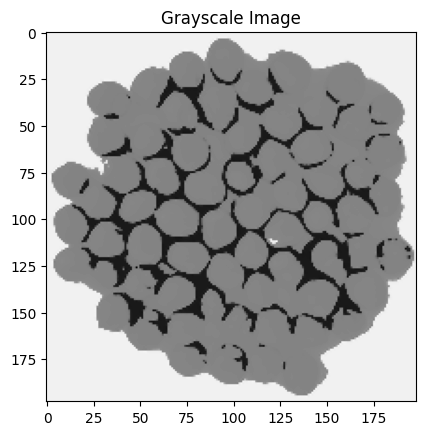

In [16]:
imgNew = np.array([[gfu(mesh(i/(img.shape[0]-1), 1-j/(img.shape[1]-1)))
                for i in range(img.shape[0])]
                for j in range(img.shape[0])]) 
plt.imshow(imgNew, cmap='gray')
plt.title('Grayscale Image')
plt.show()

Im Vergleich stehen hier die zwei Histogramme vor bzw. nach der Phasenseparation. Es gibt deutliche Phasenseparationen und die meisten Werte befinden sich bei -1, 0 oder 1.

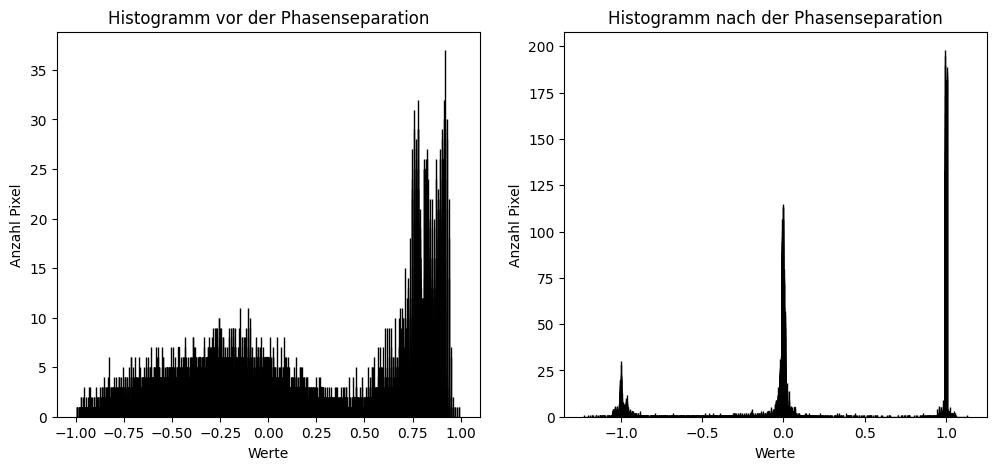

In [17]:
# Anzahl bins
num_bins = 200

# subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot des ersten Histogramms => vor der Phasenseparation
axs[0].hist(img, bins=num_bins, edgecolor='black')
#axs[0].set_yscale('log')  # y-Achse logarithmisch => Phasenseparation besser ersichlich in linearer y-Achse
axs[0].set_title('Histogramm vor der Phasenseparation')
axs[0].set_xlabel('Werte')
axs[0].set_ylabel('Anzahl Pixel')

# Plot des zweiten Histogramms => nach der Phasenseparation
axs[1].hist(imgNew, bins=num_bins, edgecolor='black')
#axs[1].set_yscale('log')  # y-axis logarithmisch
axs[1].set_title('Histogramm nach der Phasenseparation')
axs[1].set_xlabel('Werte')
axs[1].set_ylabel('Anzahl Pixel')

plt.show()